# Processing data

In [868]:
import pandas as pd
import seaborn as sns
import numpy as np 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.model_selection import cross_val_predict

In [869]:
url = r"..\data\raw\clean_house.csv"
house = pd.read_csv(url, sep=",")

In [870]:
url = r"..\data\raw\properties.csv"
secondhouse = pd.read_csv(url, sep=",")

## subsetting columns and rows

In [871]:
secondhouse.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75511 entries, 0 to 75510
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              75511 non-null  int64  
 1   price                           75511 non-null  float64
 2   property_type                   75511 non-null  object 
 3   subproperty_type                75511 non-null  object 
 4   region                          75511 non-null  object 
 5   province                        75511 non-null  object 
 6   locality                        75511 non-null  object 
 7   zip_code                        75511 non-null  int64  
 8   latitude                        61413 non-null  float64
 9   longitude                       61413 non-null  float64
 10  construction_year               42120 non-null  float64
 11  total_area_sqm                  67896 non-null  float64
 12  surface_land_sqm                

In [872]:
columns_second = secondhouse.columns.tolist()
columns_to_keep = ["id", "price", "property_type", "subproperty_type", "province", "locality", "surface_land_sqm", "nbr_bedrooms", "equipped_kitchen", "fl_furnished", "fl_open_fire", "terrace_sqm", "garden_sqm", "fl_swimming_pool", "state_building", "zip_code"]
secondhouse = secondhouse[columns_to_keep]


In [873]:
def replace_outliers(df, columns):
    for column in columns:
    # Outliers handling
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        max_value = Q3 + (1.5 * IQR)
        min_value = Q1 - (1.5 * IQR)

        outliers_mask = (df[column] < min_value) | (df[column] > max_value)
        df.loc[outliers_mask, column] = np.nan

        df.dropna(subset=[column], inplace=True)
    return df

In [874]:
lcolm = ["price"]
house = replace_outliers(house,lcolm)
secondhouse = replace_outliers(secondhouse, lcolm)

In [875]:
house['postal_code'] = house['postal_code'].astype(str).str[:2]


In [876]:
secondhouse = secondhouse[secondhouse["property_type"] == "HOUSE"]

## drop columns

In [877]:
def drop_columns(df, clist):
    ndf = df.drop(columns=clist)
    return ndf


In [878]:
todropcolumns = ["property_id", "locality_name", "latitude", "longitude", "property_type", "type_of_sale", "main_city"]
totdropcolumns = ["id", "locality", "property_type",  "fl_open_fire", "fl_furnished"]
nhouse = drop_columns(house, todropcolumns)
nsecondhouse = drop_columns(secondhouse, totdropcolumns)

In [879]:

# dropping the NaN values in the columns selected
def droping_null(df, colist):
    df.dropna(subset=colist, inplace=True)
    return df



## transform categorical data to numerical data

In [880]:
def transform_categorical2(df, clist):
    for column in clist:
        # One-hot encode the current column
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        X_ohe = ohe.fit_transform(df[[column]])
        
        # Convert the one-hot encoded features to a DataFrame
        ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        
        # Concatenate the original DataFrame with the one-hot encoded DataFrame
        df = pd.concat([df, ohe_df], axis=1)
        
        # Drop the original categorical column
        df.drop(columns=[column], inplace=True)

    return df

In [881]:
def replace_missing_mode(df, columnname):
    for column in columnname:
        condition_1 = (df[column].isnull()) | (df[column] == "MISSING") | (df[column].isna())
        mode_val = df[df[column] != "MISSING"][column].mode()[0]  # Mode value excluding "MISSING"
        if pd.isna(mode_val):  # Check if mode value is NaN
            mode_val = df[df[column] != "MISSING"][column].mode().dropna().iloc[0]  # Get the first non-NaN mode value
        df.loc[condition_1, column] = mode_val
    return df

In [882]:
def tranform_label_encoder(df, clist):
    for column in clist:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
    return df



In [883]:
def select_best(df, clistColumns, predict, k):
    sk = SelectKBest(chi2, k=k)
    sk.fit(df[clistColumns], df[predict])
    selected_columns = df.columns[sk.get_support()]
    return df[selected_columns]

    

In [884]:
clist = ["state_of_building", "property_subtype"]
plist = ["province", "kitchen_type", "postal_code"]
chouse = transform_categorical2(nhouse, plist)
chouse = tranform_label_encoder(chouse, clist)
chouse = droping_null(chouse, "terrace")
chouse = droping_null(chouse, "garden")

## Replace column names of other dataset

In [885]:
print(nhouse.columns, nsecondhouse.columns)
print(nhouse.shape[1], nsecondhouse.shape[1])

Index(['postal_code', 'property_subtype', 'price', 'number_of_rooms',
       'living_area', 'kitchen_type', 'fully_equipped_kitchen', 'furnished',
       'open_fire', 'terrace', 'terrace_area', 'garden', 'garden_area',
       'surface_of_good', 'number_of_facades', 'swimming_pool',
       'state_of_building', 'province'],
      dtype='object') Index(['price', 'subproperty_type', 'province', 'surface_land_sqm',
       'nbr_bedrooms', 'equipped_kitchen', 'terrace_sqm', 'garden_sqm',
       'fl_swimming_pool', 'state_building', 'zip_code'],
      dtype='object')
18 11


In [886]:
nsecondhouse = nsecondhouse.rename(columns={"subproperty_type": "property_subtype", "surface_land_sqm": "surface_of_good", "nbr_bedrooms": "number_of_rooms", "equipped_kitchen": "fully_equipped_kitchen", "terrace_sqm": "terrace_area", "garden_sqm": "garden_area", "fl_swimming_pool": "swimming_pool", "state_building": "state_of_building", "zip_code": "postal_code"})

In [887]:
nsecondhouse['postal_code'] = nsecondhouse['postal_code'].astype(str)

In [888]:
nsecondhouse['postal_code'] = nsecondhouse['postal_code'].astype(str).str[:2]

In [889]:
nsecondhouse = replace_missing_mode(nsecondhouse, ["fully_equipped_kitchen"])

In [890]:
clists = ["state_of_building", "property_subtype", "fully_equipped_kitchen"]
csecondhouse = tranform_label_encoder(nsecondhouse, clists)


In [891]:
csecondhouse.columns

Index(['price', 'property_subtype', 'province', 'surface_of_good',
       'number_of_rooms', 'fully_equipped_kitchen', 'terrace_area',
       'garden_area', 'swimming_pool', 'state_of_building', 'postal_code'],
      dtype='object')

In [892]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_ohe = ohe.fit_transform(csecondhouse[["province"]])
        
        # Convert the one-hot encoded features to a DataFrame
ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        
        # Concatenate the original DataFrame with the one-hot encoded DataFrame
csecondhouse = pd.concat([csecondhouse, ohe_df], axis=1)
        
        # Drop the original categorical column
csecondhouse.drop(columns=["province"], inplace=True)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_ohe = ohe.fit_transform(csecondhouse[["postal_code"]])
        
        # Convert the one-hot encoded features to a DataFrame
ohe_df = pd.DataFrame(X_ohe, columns=ohe.get_feature_names_out())
        
        # Concatenate the original DataFrame with the one-hot encoded DataFrame
csecondhouse = pd.concat([csecondhouse, ohe_df], axis=1)
        
        # Drop the original categorical column
csecondhouse.drop(columns=["postal_code"], inplace=True)

csecondhouse.head()



,price,property_subtype,surface_of_good,number_of_rooms,fully_equipped_kitchen,terrace_area,garden_area,swimming_pool,state_of_building,province_Antwerp,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
1,449000.0,7.0,680.0,2.0,1.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,501000.0,7.0,505.0,3.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,548514.0,7.0,710.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,424000.0,7.0,291.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,385000.0,7.0,309.0,3.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [893]:
csecondhouse.head()

,price,property_subtype,surface_of_good,number_of_rooms,fully_equipped_kitchen,terrace_area,garden_area,swimming_pool,state_of_building,province_Antwerp,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
1,449000.0,7.0,680.0,2.0,1.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,501000.0,7.0,505.0,3.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,548514.0,7.0,710.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,424000.0,7.0,291.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,385000.0,7.0,309.0,3.0,1.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Make the training set and test set

In [894]:
def create_X_y(df, Y):
    X = df.drop(columns=[Y])
    y = df[[Y]]
    return X, y




In [895]:
X, y = create_X_y(chouse, "price")

In [896]:
X2, y2 = create_X_y(csecondhouse, "price")

In [897]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42 )

In [898]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size= 0.2, random_state=42 )

## Imputation on the X_train, X_test

In [899]:
X_test.shape
X_train.shape 

(2428, 115)

In [900]:
X_test2.shape
X_train2.shape 

(51407, 100)

In [901]:
X_train.head(5)

,property_subtype,number_of_rooms,living_area,fully_equipped_kitchen,furnished,open_fire,terrace,terrace_area,garden,garden_area,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
3010,11,NaN,292.0,1.0,0.0,0.0,1.0,33.0,1.0,380.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
954,6,NaN,178.0,1.0,NaN,0.0,1.0,15.0,1.0,90.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10059,11,NaN,250.0,1.0,NaN,1.0,1.0,16.0,1.0,155.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2682,6,NaN,205.0,1.0,0.0,0.0,1.0,12.0,1.0,18.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3492,6,NaN,273.0,1.0,NaN,1.0,1.0,50.0,1.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [902]:
X_train2.head(5)

,property_subtype,surface_of_good,number_of_rooms,fully_equipped_kitchen,terrace_area,garden_area,swimming_pool,state_of_building,province_Antwerp,province_Brussels,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
57468,6.0,2300.0,5.0,1.0,0.0,1100.0,0.0,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20987,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60037,7.0,122.0,4.0,1.0,NaN,0.0,0.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56336,7.0,250.0,2.0,3.0,NaN,NaN,0.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62931,7.0,590.0,3.0,1.0,0.0,0.0,0.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [903]:
def replace_NaN_Categorical(df, comlist):
    df[comlist] = df[comlist].fillna(0.0)
    

In [904]:
X_train = drop_columns(X_train, ["number_of_rooms", "furnished"])
X_test = drop_columns(X_test, ["number_of_rooms", "furnished"])

In [905]:
def change_to_int(df, columnsname):
    for column in columnsname:
        df[column] = df[column].round().astype(int)
    return df


In [906]:
def replace_null_median(df, columnname):
    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].median()
    return df

In [907]:
def replace_null_mean(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = df[column].mean()
    return df

In [908]:
def replace_null_to_zero(df, columnname):

    for column in columnname:
        condition_1 = (df[column].isnull())
        df.loc[condition_1, column] = 0
    return df

### replacing values

In [909]:
X_train = replace_null_mean(X_train, ["terrace_area", "garden_area"])
X_train = replace_null_median(X_train, ["fully_equipped_kitchen", "number_of_facades"])
X_train = replace_null_to_zero(X_train, ["swimming_pool"])

X_test = replace_null_mean(X_test, ["terrace_area", "garden_area"])
X_test = replace_null_median(X_test, ["fully_equipped_kitchen", "number_of_facades"])
X_test = replace_null_to_zero(X_test, ["swimming_pool"])

In [910]:
X_train = change_to_int(X_train, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])
X_test = change_to_int(X_test, ["fully_equipped_kitchen", "number_of_facades", "swimming_pool"])

In [911]:
y_test = replace_null_mean(y_test, ["price"])
y_train = replace_null_mean(y_train, ["price"])

In [912]:
columns_with_null = X_train.columns[X_train.isnull().any()].tolist()
X_train = replace_null_to_zero(X_train, columns_with_null)
X_test = replace_null_to_zero(X_test, columns_with_null)

## Replace values for the secondhouse dataset

In [913]:
X_train2 = replace_null_mean(X_train2, ["terrace_area", "garden_area"])
X_train2 = replace_missing_mode(X_train2, ["fully_equipped_kitchen"])
X_train2 = replace_null_to_zero(X_train2, ["swimming_pool"])

X_test2 = replace_null_mean(X_test2, ["terrace_area", "garden_area"])
X_test2 = replace_missing_mode(X_test2, ["fully_equipped_kitchen"])
X_test2 = replace_null_to_zero(X_test2, ["swimming_pool"])

In [914]:
y_test2 = replace_null_mean(y_test2, ["price"])
y_train2 = replace_null_mean(y_train2, ["price"])

### scaling values

In [915]:
def scaling(df, cl):
    for column in cl:
        scaler = StandardScaler()
        #Fit and transform the data
        df[column] = scaler.fit_transform(df[[column]])
    return df

In [916]:
numerical_columns = ['living_area', 'terrace_area', 'garden_area', 'surface_of_good']
#X_test = scaling(X_test, numerical_columns)
#X_train = scaling(X_train, numerical_columns)

### testing the model

In [917]:
X_train.isnull().sum(), len(X_train)

(property_subtype          0
 living_area               0
 fully_equipped_kitchen    0
 open_fire                 0
 terrace                   0
                          ..
 postal_code_96            0
 postal_code_97            0
 postal_code_98            0
 postal_code_99            0
 postal_code_nan           0
 Length: 113, dtype: int64,
 2428)

In [918]:
X_train2.head()

,property_subtype,surface_of_good,number_of_rooms,fully_equipped_kitchen,terrace_area,garden_area,swimming_pool,state_of_building,province_Antwerp,province_Brussels,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
57468,6.0,2300.0,5.0,1.0,0.000000,1100.000000,0.0,5.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20987,NaN,NaN,NaN,1.0,9.455449,148.094558,0.0,NaN,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60037,7.0,122.0,4.0,1.0,9.455449,0.000000,0.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56336,7.0,250.0,2.0,3.0,9.455449,148.094558,0.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62931,7.0,590.0,3.0,1.0,0.000000,0.000000,0.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [919]:
X_train2.isnull().sum(), len(X_train2)

(property_subtype          22967
 surface_of_good           22967
 number_of_rooms           22967
 fully_equipped_kitchen        0
 terrace_area                  0
                           ...  
 postal_code_96             7950
 postal_code_97             7950
 postal_code_98             7950
 postal_code_99             7950
 postal_code_nan            7950
 Length: 100, dtype: int64,
 51407)

In [930]:
X_train2 = replace_null_median(X_train2, ["property_subtype", "number_of_rooms"])
X_test2 = replace_null_median(X_test2, ["property_subtype", "number_of_rooms"])

X_train2 = replace_null_mean(X_train2, ["surface_of_good"])
X_test2 = replace_null_mean(X_test2, ["surface_of_good"])

columns_with_null = X_train2.columns[X_train2.isnull().any()].tolist()
X_train2 = replace_null_to_zero(X_train2, columns_with_null)
X_test2 = replace_null_to_zero(X_test2, columns_with_null)

In [931]:
X_train2.isnull().sum(), len(X_train2)

(property_subtype          0
 surface_of_good           0
 number_of_rooms           0
 fully_equipped_kitchen    0
 terrace_area              0
                          ..
 postal_code_96            0
 postal_code_97            0
 postal_code_98            0
 postal_code_99            0
 postal_code_nan           0
 Length: 100, dtype: int64,
 51407)

In [932]:
X_train2.head()

,property_subtype,surface_of_good,number_of_rooms,fully_equipped_kitchen,terrace_area,garden_area,swimming_pool,state_of_building,province_Antwerp,province_Brussels,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
57468,6.0,2300.000000,5.0,1.0,0.000000,1100.000000,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20987,7.0,741.940682,3.0,1.0,9.455449,148.094558,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60037,7.0,122.000000,4.0,1.0,9.455449,0.000000,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56336,7.0,250.000000,2.0,3.0,9.455449,148.094558,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62931,7.0,590.000000,3.0,1.0,0.000000,0.000000,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [920]:
y_test.isnull().sum()

price    0
dtype: int64

In [921]:
y_test2.isnull().sum()

price    0
dtype: int64

In [933]:
X_train.head()

,property_subtype,living_area,fully_equipped_kitchen,open_fire,terrace,terrace_area,garden,garden_area,surface_of_good,number_of_facades,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
3010,11,292.0,1,0.0,1.0,33.0,1.0,380.0,585.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
954,6,178.0,1,0.0,1.0,15.0,1.0,90.0,210.0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10059,11,250.0,1,1.0,1.0,16.0,1.0,155.0,256.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2682,6,205.0,1,0.0,1.0,12.0,1.0,18.0,75.0,2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3492,6,273.0,1,1.0,1.0,50.0,1.0,160.0,326.0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [934]:
X_train2.head()

,property_subtype,surface_of_good,number_of_rooms,fully_equipped_kitchen,terrace_area,garden_area,swimming_pool,state_of_building,province_Antwerp,province_Brussels,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
57468,6.0,2300.000000,5.0,1.0,0.000000,1100.000000,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20987,7.0,741.940682,3.0,1.0,9.455449,148.094558,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60037,7.0,122.000000,4.0,1.0,9.455449,0.000000,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56336,7.0,250.000000,2.0,3.0,9.455449,148.094558,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62931,7.0,590.000000,3.0,1.0,0.000000,0.000000,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [935]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [936]:
regressor = LinearRegression()
regressor.fit(X_train2, y_train2)

LinearRegression()

In [937]:
regressor.fit(X_train2, y_train2)

LinearRegression()

In [938]:
regressor.score(X_train, y_train)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- garden
- kitchen_type_HYPER_EQUIPPED
- kitchen_type_INSTALLED
- kitchen_type_NOT_INSTALLED
- kitchen_type_SEMI_EQUIPPED
- ...
Feature names seen at fit time, yet now missing:
- number_of_rooms
- province_Antwerp
- province_Brussels
- province_East Flanders
- province_Flemish Brabant
- ...


In [939]:
X_train2.head()

,property_subtype,surface_of_good,number_of_rooms,fully_equipped_kitchen,terrace_area,garden_area,swimming_pool,state_of_building,province_Antwerp,province_Brussels,...,postal_code_91,postal_code_92,postal_code_93,postal_code_94,postal_code_95,postal_code_96,postal_code_97,postal_code_98,postal_code_99,postal_code_nan
57468,6.0,2300.000000,5.0,1.0,0.000000,1100.000000,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20987,7.0,741.940682,3.0,1.0,9.455449,148.094558,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60037,7.0,122.000000,4.0,1.0,9.455449,0.000000,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56336,7.0,250.000000,2.0,3.0,9.455449,148.094558,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
62931,7.0,590.000000,3.0,1.0,0.000000,0.000000,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [940]:
regressor.score(X_train2, y_train2)

0.16263201440307018

In [ ]:
y_pred = regressor.predict(X_test)
score = r2_score(y_test, y_pred)
score

0.33753840260836065

In [ ]:
y_pred = regressor.predict(X_test2)
score = r2_score(y_test2, y_pred2)
score

## Cross validation

In [ ]:
cv_pred = cross_val_predict(estimator=regressor, X=X_train, y=y_train, cv = 5)
#print("CV scores:", scores)
#print("mean score", scores.mean())
#print("std", scores.std())


In [ ]:
print("Accuracy score:", r2_score(y_true=y_train, y_pred=cv_pred))

Accuracy score: -2863404849.1346354


## Plotting the result

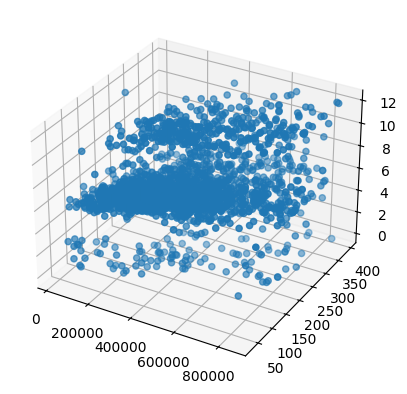

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y_train['price'], X_train['living_area'], X_train['property_subtype'])